# **Import and unzip**

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Get current working directory
cwd = os.getcwd()

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!unzip /content/drive/MyDrive/visual-question-answering/anndl-2020-vqa.zip > /dev/null

# **Dataset**

## Tokenization

In [5]:
labels_dict = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

In [6]:
# Prepare dataset
# ---------------
import pandas as pd

train_questions = pd.read_json('/content/VQA_Dataset/train_questions_annotations.json')
test_questions = pd.read_json('/content/VQA_Dataset/test_questions.json')
train_questions
test_questions

#Questions
questions = list(train_questions.iloc[0])
#Answers
answers = list(train_questions.iloc[2])
#Images
images = np.array(train_questions.iloc[1])

#transform answers into values of dictionary
for i in range(len(answers)):
  answers[i] = labels_dict[answers[i]]



,117792,117790,117791,55360,169490,169492,65022,33712,87880,87881,87882,100050,100052,15272,15270,25920,25921,25922,127540,127542,107960,107961,107962,154920,154921,13290,13292,146570,156160,156161,156162,157040,145200,145201,166651,1281,65251,65252,71510,71511,...,285092,287992,287990,287991,257240,257242,211260,291941,291942,212781,212782,218412,278370,278371,233210,233211,206120,206121,206122,227032,227031,298600,298601,298602,264752,264750,201121,244912,244910,244911,236752,265471,206180,206181,206182,237780,237781,237782,288361,288362
question,Who looks happier?,Where is the woman sitting?,Where is the man sitting?,Is this man hungry?,Who is holding the football?,Does this woman tie her shoes in the morning?,Is the man eating a hotdog?,What is the predominant color of the room?,Is the cat running?,Do these animals normally hang out together?,Is the mouse under the chair?,Is that a cat on the sofa?,Is there books on the bookshelf?,How many people are in the room?,What color is the dog?,Is little baby trying to walk?,Is there a woman on the couch?,Is the couch sitting against the wall?,Is the man dancing with two turtles?,Is the man afraid of the turtles?,What kind of ball is that?,Is the man playing soccer?,Are they wearing shorts?,How many bushes are in the background?,What is the girl doing?,What is the woman doing outside?,What is on the blanket?,Is the old man happy?,How many slices of watermelon are there?,Who cooked the pie?,Does the dog want the ball?,Does the woman's dentist recommend this dessert?,What color is the bike?,Is the man injured?,How old is young kid?,Is the dog on the rug?,Where is the man sitting?,There is pie for how many people?,What many pairs of pants are in this scene?,IS the dog going to eat the watermelon?,...,Do they notice the deer?,What color is the dog?,Is it safe for the baby to be this close to th...,What color is the rug?,Are the sofas facing each other?,Is there a fireplace?,Do the squirrels have the park to themselves?,Are they both sitting on the rug?,Can the robot think?,What kind of wine is being served?,Is there a lot of food?,What color is the fire?,Is the person older the President Obama?,Has this woman injured her leg?,Are the two people holding hands?,Does the cat belong to the couple?,Do all the people in picture have a seat?,Are there enough plates for everyone there?,Are the women wearing heels?,Is he eating?,Is the boy home for a snack?,How many white fabrics are in the picture?,Is the dog trying to climb up on the chair?,Is there a kitten on one of the chairs?,Does his shirt and pants match?,Is he riding a bike?,Is the man sitting too close to the fireplace?,Is the table lower than the plant?,Does the cat want the man?,Are the curtains the same?,How many bicycle re in the picture?,What is the woman standing behind?,What color is her shirt?,What sport can be played?,Is the sky sunny?,What animal is that?,Is there a fire in the fireplace?,How many pillows on the sofa?,How many people are there?,What is on the pillow?
image_id,11779,11779,11779,5536,16949,16949,6502,3371,8788,8788,8788,10005,10005,1527,1527,2592,2592,2592,12754,12754,10796,10796,10796,15492,15492,1329,1329,14657,15616,15616,15616,15704,14520,14520,16665,128,6525,6525,7151,7151,...,28509,28799,28799,28799,25724,25724,21126,29194,29194,21278,21278,21841,27837,27837,23321,23321,20612,20612,20612,22703,22703,29860,29860,29860,26475,26475,20112,24491,24491,24491,23675,26547,20618,20618,20618,23778,23778,23778,28836,28836
answer,man,blanket,bench,yes,man,no,yes,brown,no,no,yes,no,no,1,gray,yes,yes,no,yes,no,soccer,yes,no,3,playing,sitting,food,no,2,man,yes,no,orange,no,1,yes,blanket,2,1,no,...,no,gray,no,red,yes,no,yes,yes,no,white,yes,orange,yes,no,yes,yes,no,no,yes,no,yes,2,yes,yes,yes,no,yes,no,yes,no,1,tree,white,baseball,yes,dog,yes,2,0,book


,169491,33711,100051,15271,13291,146571,145202,166652,1282,71512,24691,187130,31122,125731,125732,174961,125980,131642,135272,195130,195131,195132,11892,136812,84622,117291,21252,64220,84430,113740,113742,41071,27502,49681,49682,147491,19671,95480,138791,163772,...,291441,209001,265941,230402,291641,239200,212821,270940,223840,223842,273762,271841,243621,229732,233222,242891,204530,245201,272200,245242,233832,233831,274692,214480,233460,225972,217752,261201,255501,204651,242760,288882,282060,212780,243542,278372,264751,236751,265472,218312
question,How is the weather?,What is the woman holding?,How many pillows?,Is the man falling?,How many logs on the grass?,How many mice are crawling?,How many logs in the scene?,Are the children the same ethnicity?,Do they look sad?,Is it daylight?,Does the woman have curly hair?,What color are the trees?,How many deer are under a tree?,Are there any ducks in the pond?,Are the ducks going to eat the fish?,Are there any fish in the pond?,What color is the ground?,IS the women watching TV?,Are there any dolls in the room for the dollho...,How many turtles are around the pond?,Is the girl all alone?,What sport does she have the equipment to play?,Why would you say this woman is strong?,How many clouds are there?,How many mushrooms are there?,How many windows?,Is the window a rectangle?,Where are the apples?,Does the man have a good heart?,Is the man kicking the dog?,How many cats are there?,Where are the people sitting?,Do they have matching shirts?,How many children?,Is the sun out in the picture on the wall?,Is there a place to sit?,How many logs are in the fireplace?,What color is the cat?,Was he expecting someone?,How many places to play are there?,...,Is he laughing?,How many pictures are on the wall?,How many logs?,How many clouds in the sky?,Where is the dog?,Is the girl jumping?,Is there a TV?,Is this young man trying to pet a dog?,What color are the chairs?,How many chairs are in the room?,Is the lady in the red shirt hot from the fire?,Is his foot wet?,What is the dog doing in front of the fireplace?,Are they a couple?,Is the puppy playing with the kitten?,What is on TV?,Are there pictures on the wall?,Does she prefer jump rope or soccer?,Is there wood in the fireplace?,Is the sky clear?,Is the cat after the woman for attention?,What color is the cat?,What color is the woman's shirt?,Is that painting your style?,What color is the cat?,How many children are standing?,Do the animals think the woman is Snow White?,How many trees are there?,What color is the moped?,Where is the cheese?,Is it a cloudy day?,Is the TV turned on?,Are there clouds in the sky?,Is this a party?,What color is the dog?,Is there anyone with her?,How many trees are there?,How many turtles are there?,Is the fish in the pond spotted?,What is the portrait of?
image_id,16949,3371,10005,1527,1329,14657,14520,16665,128,7151,2469,18713,3112,12573,12573,17496,12598,13164,13527,19513,19513,19513,1189,13681,8462,11729,2125,6422,8443,11374,11374,4107,2750,4968,4968,14749,1967,9548,13879,16377,...,29144,20900,26594,23040,29164,23920,21282,27094,22384,22384,27376,27184,24362,22973,23322,24289,20453,24520,27220,24524,23383,23383,27469,21448,23346,22597,21775,26120,25550,20465,24276,28888,28206,21278,24354,27837,26475,23675,26547,21831


Answers Frequency

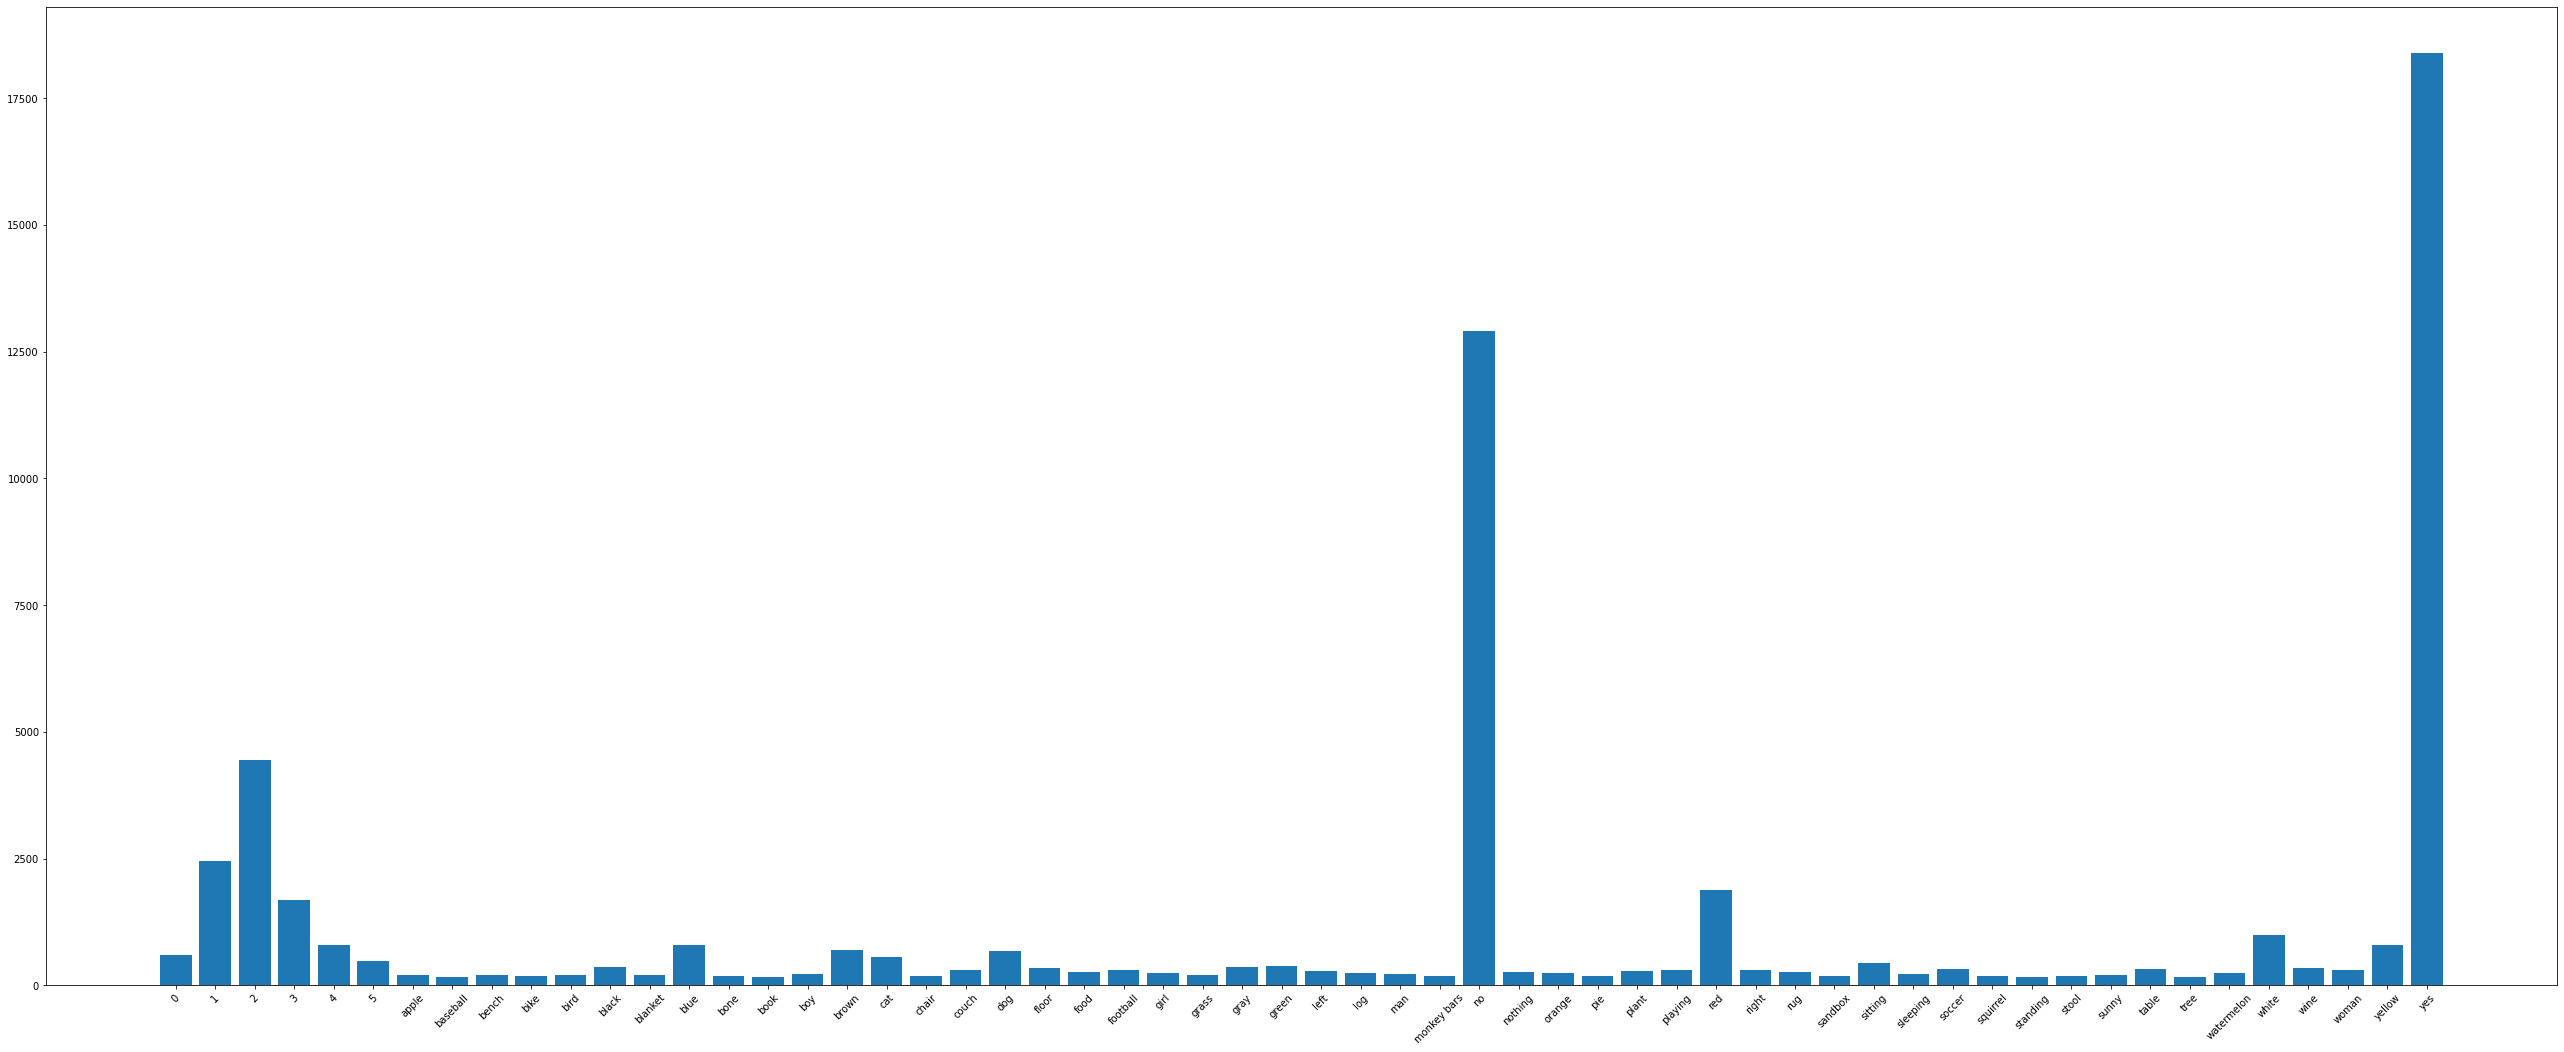

In [9]:
classes = {}
chart = {}
total = 0
for i in range(58):
  count = 0
  for j in answers:
    if(j == i):
      count = count + 1
  classes[i] = count
  chart[list(labels_dict.keys())[i]] = count
  total += count

_ = plt.figure(figsize = (45,18))   
_ = plt.bar(x = chart.keys(), height = chart.values())
_ = plt.xticks(rotation=45)

Compute weights of classes

In [10]:
class_weight = {}

keys = list(labels_dict)
for i in range(58):
  class_weight[labels_dict[keys[i]]] =  math.log(100 * total/classes[i])


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create Tokenizer to convert words to integers
questions_tokenizer = Tokenizer()
questions_tokenizer.fit_on_texts(questions)
questions_tokenized = questions_tokenizer.texts_to_sequences(questions)

questions_wtoi = questions_tokenizer.word_index
print('Total word in question:', len(questions_wtoi))

max_questions_length = max(len(sentence) for sentence in questions_tokenized)
print('Max length question:', max_questions_length)


Total word in question: 4640
Max length question: 21


## Image Augmentation

In [12]:
!pip install albumentations==0.5.2 > /dev/null
#pip freeze | grep albumentations

In [13]:
import albumentations as A

In [14]:
# Albumentation
A_transform = A.Compose([
  A.HorizontalFlip(p=0.5),
  A.Blur(p=0.2, blur_limit=2),
  A.Downscale(scale_min=0.5,scale_max=0.9,p=0.15),
  A.GaussNoise(p=0.3),
  A.ElasticTransform(p=0.2, alpha=120, sigma=120 * 0.1, alpha_affine=120 * 0.1),
  A.Rotate(p=0.4, border_mode=0, limit=40),
])

## Custom Dataset

In [17]:
from PIL import Image
import cv2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

img_w = 700
img_h = 400
max_questions_length = 21
max_answers_length = 1
num_classes= 58

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(
    self, dataset_dir,
    which_subset,
    img_generator=None,
    preprocessing_function=None
  ):

    if which_subset == 'training':
     subset_filenames = list(train_questions.iloc[1])[int(len(train_questions.iloc[1])*0.15)+1:]
     #Questions
     questions = list(train_questions.iloc[0])[int(len(train_questions.iloc[0])*0.15)+1:]
     #Answers
     answers = list(train_questions.iloc[2])[int(len(train_questions.iloc[2])*0.15)+1:]
    elif which_subset == 'validation':
     subset_filenames = list(train_questions.iloc[1])[:int(len(train_questions.iloc[1])*0.15)]
     #Questions
     questions = list(train_questions.iloc[0])[:int(len(train_questions.iloc[0])*0.15)]
     #Answers
     answers = list(train_questions.iloc[2])[:int(len(train_questions.iloc[2])*0.15)]
    elif which_subset == "test":
     subset_filenames = list(test_questions.iloc[1])
     #Questions
     questions = list(test_questions.iloc[0])
     #Answers
     #answers = list(test_questions.iloc[2])
  

    # Create Tokenizer to convert words to integers
    questions_tokenizer = Tokenizer()
    questions_tokenizer.fit_on_texts(list(train_questions.iloc[0]))
    questions_tokenized = questions_tokenizer.texts_to_sequences(questions)
    len(questions_tokenized)

    #If dataset is training set or validation set, trasform answer into label
    if(which_subset != 'test'):
      for i in range(len(answers)):
       answers[i] = labels_dict[answers[i]]
    else:
      answers = [] 
    

    questions_encoder_inputs = pad_sequences(questions_tokenized, maxlen=max_questions_length)
   

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.questions = questions_encoder_inputs
    self.answers=answers
    self.img_generator = img_generator
    self.preprocessing_function = preprocessing_function
    self.question_tokenizer = questions_tokenizer

  def __len__(self):
    return len(self.questions)

  def get_questions_tokenizer(self):
    return self.question_tokenizer


  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    curr_question = (self.questions[index])
    if(self.which_subset != 'test'):
      curr_answer = (self.answers[index])

      zer = np.zeros((num_classes,),dtype=float)
      zer[curr_answer] = 1 

    img = cv2.imread(os.path.join(self.dataset_dir, 'Images/', curr_filename + '.png'))

    

   # img = Image.open(os.path.join(self.dataset_dir, 'Images/', curr_filename + '.png'))
   # print(curr_filename)
    


    # Resize image and mask
    img = cv2.resize(img, (int(700/2),int(400/2)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img.resize((700,400))
    img_arr = np.array(img)

    if(self.which_subset == "training"):
      # img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
      # img_arr = self.img_generator.apply_transform(img_arr, img_t)
      transformed = self.img_generator(image=img_arr)
      img_arr = transformed["image"]

    if(self.which_subset == 'test'):
      return (curr_question,  img_arr)

    return (curr_question,  img_arr), zer

In [18]:
dataset = CustomDataset("/content/VQA_Dataset", 'training', img_generator=A_transform) #preprocessing_function=preprocess_input
dataset_valid = CustomDataset("/content/VQA_Dataset", 'validation') #preprocessing_function=preprocess_input
dataset_test = CustomDataset("/content/VQA_Dataset", 'test' )

In [19]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=((tf.int32, tf.float32), tf.int32),
                                               output_shapes=(([max_questions_length], [int(img_h/2), int(img_w/2), 3]), [num_classes]))

train_dataset = train_dataset.batch(32)

train_dataset = train_dataset.repeat()



valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(( tf.int32, tf.float32), tf.int32),
                                               output_shapes=(([max_questions_length], [int(img_h/2), int(img_w/2), 3]), [num_classes]))

valid_dataset = valid_dataset.batch(1)

valid_dataset = valid_dataset.repeat()

test_dataset = tf.data.Dataset.from_generator(lambda: dataset_test,
                                               output_types=(( tf.int32, tf.float32)),
                                               output_shapes=(([max_questions_length], [int(img_h/2), int(img_w/2), 3])))
test_dataset = test_dataset.batch(1)
test_dataset = test_dataset.repeat()

## Plot

In [20]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

iterator = iter(train_dataset)

['is there a robot on one of the shelves']

'yes'

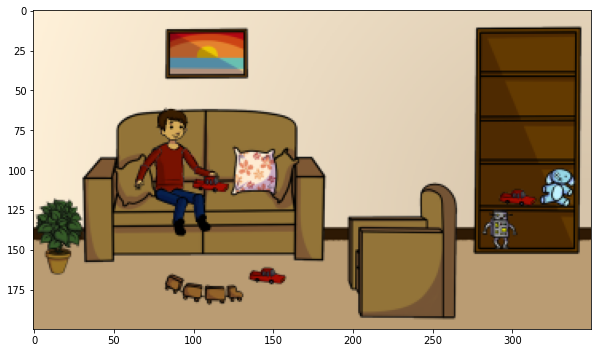

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

augmented_img_question, answer = next(iterator)
augmented_img = augmented_img_question[1][0]   # First element
augmented_img = augmented_img  # denormalize


ax.imshow(np.uint8(augmented_img))
# augmented_img_question[0]
dataset.get_questions_tokenizer().sequences_to_texts([augmented_img_question[0][0].numpy().tolist()])
key_list = list(labels_dict.keys())
val_list = list(labels_dict.values())
key_list[val_list.index(tf.keras.backend.get_value(tf.argmax(answer[0], axis=0)))]
plt.show()

# **Model**

In [22]:
# Creating Model
# --------------
EMBEDDING_SIZE = 256
num_classes = 58
max_questions_length = 21

# Question part model

encoder_input = tf.keras.Input(shape=[max_questions_length])
encoder_embedding_layer = tf.keras.layers.Embedding(input_dim = len(questions_wtoi)+1, output_dim = 512, input_length=max_questions_length, mask_zero=True)(encoder_input)
encoded_question = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_SIZE, unroll=True, recurrent_dropout=0.3,activation="relu"))(encoder_embedding_layer)



# CNN part

model_img = tf.keras.models.Sequential()
xception = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=[200,350, 3])

finetuning = True

if finetuning:
  freeze_until = 20 # layer from which we want to fine-tune

for layer in xception.layers:
 layer.trainable = False

for layer in xception.layers[:freeze_until]:
  layer.trainable = True

model_img.add(xception)
model_img.add(tf.keras.layers.Flatten())
model_img.add(tf.keras.layers.Dense(EMBEDDING_SIZE, activation="relu"))
model_img.add(tf.keras.layers.Dropout(0.3))

image_input = tf.keras.Input(shape=[200,350, 3])
out_image = model_img(image_input)


vqa_model_mul = tf.keras.layers.concatenate(inputs = [out_image, encoded_question])
vqa_model_fc = tf.keras.layers.Dense(128, activation="relu")(vqa_model_mul)
vqa_model_out = tf.keras.layers.Dense(num_classes, activation="softmax")(vqa_model_fc)


model = tf.keras.Model(inputs =  [encoder_input, image_input], outputs = vqa_model_out)

83689472/83683744 [==============================] - 0s 0us/step


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 200, 350, 3) 0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 21, 512)      2376192     input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256)          61231912    input_3[0][0]                    
______________________________________________________________________________________________

# **Fit**

In [ ]:
# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
load = False

if load:
  model.load_weights('/path/to/checkpoint')

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join('/content/drive/My Drive/KerasRNN', 'VQA')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

exp_name = 'exp'

exp_dir = os.path.join(exps_dir, exp_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# ----------------

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
#tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
#                                             profile_batch=0,
#                                             histogram_freq=1)  # if 1 shows weights histograms
#callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
    callbacks.append(es_callback)

# ---------------------------------


model.fit(train_dataset, 
          epochs=40,
          steps_per_epoch= len(dataset)/32,
          batch_size = 32,
          class_weight = class_weight,
          validation_data=valid_dataset,
          validation_steps= len(dataset_valid),
          shuffle = True,
          callbacks = callbacks)
# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/40
1562/1562 [==============================] - 1694s 1s/step - loss: 19.9571 - accuracy: 0.3506 - val_loss: 1.5407 - val_accuracy: 0.4422
Epoch 2/40
1562/1562 [==============================] - 1629s 1s/step - loss: 13.0776 - accuracy: 0.4421 - val_loss: 1.3809 - val_accuracy: 0.4720
Epoch 3/40
1562/1562 [==============================] - 1618s 1s/step - loss: 11.3316 - accuracy: 0.5046 - val_loss: 1.2644 - val_accuracy: 0.5071
Epoch 4/40
1562/1562 [==============================] - 1586s 1s/step - loss: 10.2496 - accuracy: 0.5433 - val_loss: 1.1808 - val_accuracy: 0.5406
Epoch 5/40
1562/1562 [==============================] - 1562s 999ms/step - loss: 9.3604 - accuracy: 0.5693 - val_loss: 1.1006 - val_accuracy: 0.5614
Epoch 6/40
1562/1562 [==============================] - 1598s 1s/step - loss: 8.6812 - accuracy: 0.5909 - val_loss: 1.0688 - val_accuracy: 0.5690
Epoch 7/40
1562/1562 [==============================] - 1604s 1s/step - loss: 8.1866 - accuracy: 0.6039 - val_loss: 1

KeyboardInterrupt: ignored

# **Evaluate**

In [ ]:
model.evaluate(valid_dataset, steps = 8824)

In [ ]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(str(key) + ',' + str(value) + '\n')

In [ ]:
results = {}
image_names =  np.array(test_questions.iloc[1])
keys = list(test_questions.columns)
len(keys)
iterator =  test_dataset.as_numpy_iterator()

for i in range(len(dataset_test)):
  augmented_img_question = next(iterator)
  answer_model = model.predict(augmented_img_question)
  results[keys[i]] = tf.keras.backend.get_value(tf.argmax(answer_model[0], axis=0))

6372

In [ ]:
create_csv(results)